## Sentiment Analysis on US Twitter Airlines dataset

 Sentiment analysis  is a very common applications in Natural Language processing. We will analyze the Twitter accounts of US airlines to better understand costumer sentiment towards various airlines. This is an example of Natural Language Processing (NLP) applications of Sentiment Classification.

In [1]:
!pip install catboost
!pip install shap

In [2]:
import numpy as np  
import pandas as pd  
import re  
import nltk
import seaborn as sns

from nltk.corpus import stopwords  
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import DMatrix
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import keras
import keras as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical, np_utils
from keras.preprocessing.text import Tokenizer

from keras.layers import Embedding, Dropout, Activation, Conv1D, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.optimizers import Adam

from catboost import CatBoostClassifier, Pool

import shap

import matplotlib.pyplot as plt  
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [3]:
# load JS visualization code to notebook
shap.initjs()

In [0]:
def neg_log_loss(y_true, y_pred,
                 labels=['negative', 'neutral', 'positive']):
  return log_loss(y_true, y_pred, 
                  eps=1e-15, 
                  labels=labels)

def f1_scores(y_true, y_pred,
              labels=[0, 1, 2],
              average='weighted',
              sample_weight=None):
  return f1_score(y_true, y_pred, 
                  labels=labels,
                  average=average, 
                  sample_weight=sample_weight)

def geometric_mean(y_true, y_pred, average='weighted', #'multiclass'
                   labels=['negative', 'neutral', 'positive'], 
                   sample_weight=None, correction=0.0):
  return geometric_mean_score(y_true, y_pred, 
                              labels=labels, 
                              average=average, 
                              sample_weight=sample_weight, 
                              correction=correction)

In order to feed this data into our RNN, all input documents must have the same length. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews with a null value (0). 

In [0]:
# Prepare reviews for check
def prepare_reviews(Check_set, max_review_len=100):
  # Tokenize words/reviews
  tokenizer = Tokenizer(lower = True, num_words=max_fatures, split=' ')
  Check_seq = tokenizer.texts_to_sequences(Check_set)
  # Pad sequences with zeros
  Check_pad = pad_sequences(Check_seq, 
                            maxlen = max_review_len, #None
                            dtype='int32', 
                            padding='pre', 
                            truncating='pre',
                            value=0.0,
                           )
  
  return Check_pad

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
#corpus = []
#for i in range(0, 10000):
#    review = re.sub('[^a-zA-Z]', ' ', df['Text'][i])
#    review = review.lower()
#    review = review.split()
#    ps = PorterStemmer()
#    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
#    review = ' '.join(review)
#    corpus.append(review)

In [8]:
plot_size = plt.rcParams["figure.figsize"]  
print(plot_size[0])  
print(plot_size[1])

plot_size[0] = 8  
plot_size[1] = 6  
plt.rcParams["figure.figsize"] = plot_size  

6.0
4.0


In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred);
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    #classes = np.unique(y_true)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots();
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap);
    ax.figure.colorbar(im, ax=ax);
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label');

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor");

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black");
    fig.tight_layout();
    return ax;

In [0]:
# data to plot
def vertical_chart(n_classes = 3,
                   means_precision = [0.82, 0.62, 0.70], 
                   means_recall    = [0.90, 0.48, 0.62]):
  

  # create plot
  fig, ax = plt.subplots()
  index = np.arange(n_classes)
  bar_width = 0.35
  opacity = 0.8

  rects1 = plt.bar(index, means_precision, bar_width,
  alpha=opacity,
  color='b',
  label='Precision')

  rects2 = plt.bar(index + bar_width, means_recall, bar_width,
  alpha=opacity,
  color='g',
  label='Recall')

  plt.xlabel('Histogram bins')
  plt.ylabel('Precision and Recall %nage')
  plt.title('Precision and Recall percentage')
  plt.xticks(index + bar_width, ('Negative', 'Neutral', 'Positive'))
  plt.legend()

  plt.tight_layout()
  
  return plt.show()

In [0]:
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"  
airline_tweets = pd.read_csv(data_source_url)#.sample(100, axis=0)

In [12]:
airline_tweets.head()  

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


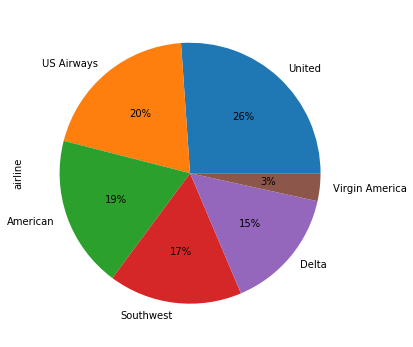

In [13]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

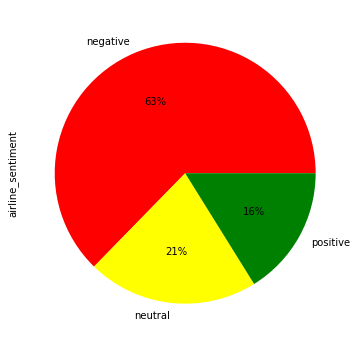

In [14]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', 
                                                     autopct='%1.0f%%', 
                                                     colors=["red", "yellow", "green"])  

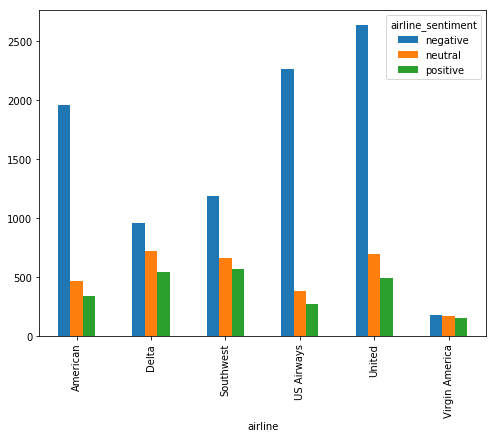

In [15]:
airline_sentiment = airline_tweets.groupby(['airline', 
                                            'airline_sentiment']).airline_sentiment.count().unstack()  
airline_sentiment.plot(kind='bar')  

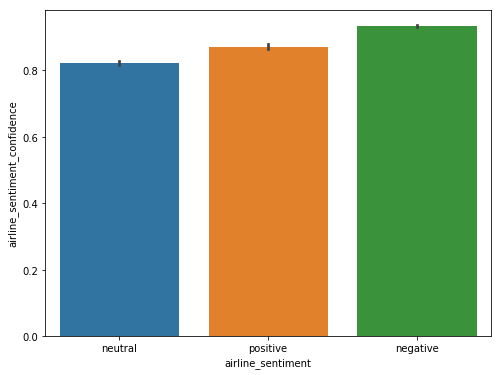

In [16]:
sns.barplot(x='airline_sentiment', 
            y='airline_sentiment_confidence', 
            data=airline_tweets)

In [0]:
features = airline_tweets.iloc[:, 10].values  
labels   = airline_tweets.iloc[:, 1].values  

### Loading and Cleaning Reviews

*   prepare the data using the following way:
*   Split tokens on white space.
*   Remove all punctuation from words.
*   Remove all words that are not purely comprised of alphabetical characters.
*   Remove all words that are known stop words.
*   Remove all words that have a length <= 1 character.



In [0]:
processed_features = []

for sentence in range(0, len(features)):  
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

Next, we can use the CountVectorizer provided by the scikit-learn library to vectorize sentences. It takes the words of each sentence and creates a vocabulary of all the unique words in the sentences. This vocabulary can then be used to create a feature vector of the count of the words.

In [0]:
# Bag-of-words (BOW) model to vectorize the sentences/text. 
vectorizer = CountVectorizer(max_features=2500,
                             min_df=7, 
                             max_df=0.8, 
                             lowercase=True,
                             stop_words=stopwords.words('english')
                            )  
processed_features = vectorizer.fit_transform(processed_features).toarray()  

In [0]:
# train test split dataset
X_train, X_test, y_train, y_test = train_test_split(processed_features, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=42)  

In [21]:
class_names = np.unique(y_test)
print(class_names)

['negative' 'neutral' 'positive']


### RandomForest modelling

In [0]:
# Test classifier
model = RandomForestClassifier(n_estimators=200, random_state=42)  

In [23]:
%%time
# train model on training dataset
model.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
# make model predictions on test dataset
y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[1670  153   66]
 [ 259  264   57]
 [ 109   66  284]]


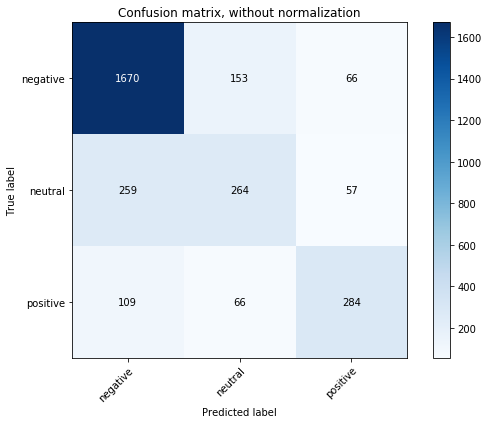

In [25]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization');

Normalized confusion matrix
[[0.88406564 0.08099524 0.03493912]
 [0.44655172 0.45517241 0.09827586]
 [0.23747277 0.14379085 0.61873638]]


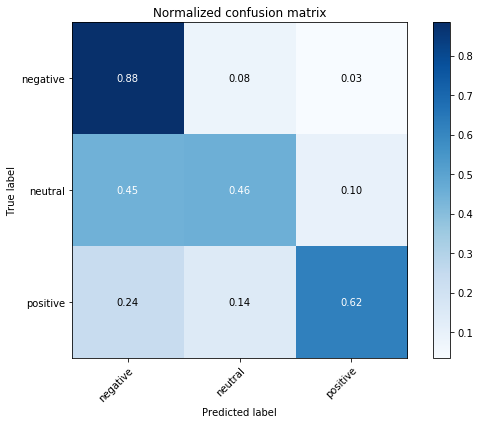

In [26]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [27]:
print("classification report:")
print(classification_report(y_test, y_pred,
                            target_names=class_names))

classification report:
              precision    recall  f1-score   support

    negative       0.82      0.88      0.85      1889
     neutral       0.55      0.46      0.50       580
    positive       0.70      0.62      0.66       459

   micro avg       0.76      0.76      0.76      2928
   macro avg       0.69      0.65      0.67      2928
weighted avg       0.75      0.76      0.75      2928



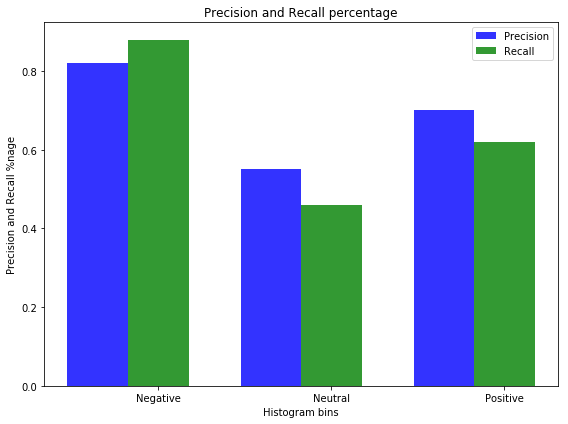

In [29]:
vertical_chart(means_precision  = [0.82, 0.55, 0.70], 
                   means_recall = [0.88, 0.46, 0.62])

### One-vs-the-rest (OvR) multiclass strategy

The one-vs-allstrategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [0]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, 
                                                   criterion = 'entropy',
                                                   random_state=42))

In [31]:
%%time
# train model on training dataset
model.fit(X_train, y_train)

CPU times: user 3min 18s, sys: 207 ms, total: 3min 19s
Wall time: 3min 19s


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [0]:
# make model predictions on test dataset
y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[1703  130   56]
 [ 259  267   54]
 [  99   63  297]]


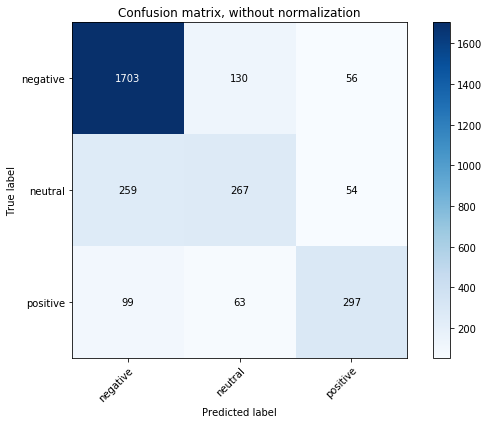

In [33]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization');

Normalized confusion matrix
[[0.9015352  0.06881948 0.02964531]
 [0.44655172 0.46034483 0.09310345]
 [0.21568627 0.1372549  0.64705882]]


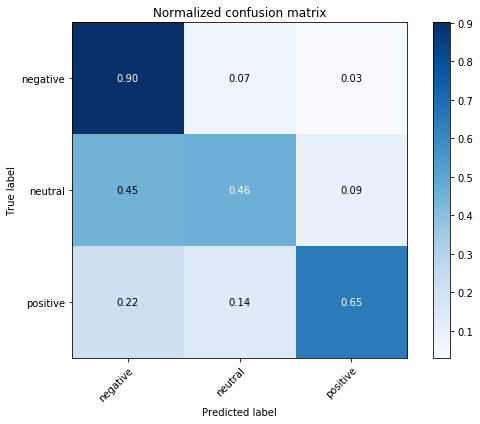

In [34]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [35]:
print("classification report:")
print(classification_report(y_test, y_pred,
                            target_names=class_names))

classification report:
              precision    recall  f1-score   support

    negative       0.83      0.90      0.86      1889
     neutral       0.58      0.46      0.51       580
    positive       0.73      0.65      0.69       459

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.71      0.67      0.69      2928
weighted avg       0.76      0.77      0.77      2928



In [0]:
vertical_chart(means_precision  = [0.83, 0.58, 0.73], 
                   means_recall = [0.90, 0.46, 0.65])

### Gaussian processs model

Gaussian process classification (GPC) based on Laplace approximation.  The Laplace approximation is used for approximating the non-Gaussian posterior by a Gaussian.

In [0]:
model = GaussianProcessClassifier(kernel=RBF(1.0), # default
                                  multi_class='one_vs_rest',
                                  max_iter_predict=100,
                                  random_state=42)

In [0]:
%%time
# train model on training dataset
model.fit(X_train, y_train)

In [0]:
# make model predictions on test dataset
y_pred = model.predict(X_test)

In [0]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization');

In [0]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [0]:
print("classification report:")
print(classification_report(y_test, y_pred,
                            target_names=class_names))

In [0]:
vertical_chart(means_precision  = [0.83, 0.58, 0.73], 
                   means_recall = [0.90, 0.46, 0.65])

### XGBoost modeling

https://www.kaggle.com/tilii7/xgboost-bayesian-optimization

In [0]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)

# digitize categorical label data
y_train_encoded = encoder.transform(y_train)
y_test_encoded  = encoder.transform(y_test)

# one hot encode
y_train_ohe = to_categorical(y_train_encoded, num_classes=3)
y_test_ohe  = to_categorical(y_test_encoded,  num_classes=3)

# invert encoding
#y_test_decorded = np.argmax(y_test_ohe, axis=1) # i.e y_test_encoded

In [0]:
# convert to xgboost dmatrix format (label parameter does not support type string)
dtrain_ohe = xgb.DMatrix(X_train, label=y_train_ohe)
dtest_ohe  = xgb.DMatrix(X_test,  label=y_test_ohe)

**Note:** XGBClassifier supports automatic conversion from string labels to numeric labels, to follow conventions of scikit-learn.

#### XGB classifier with gbtree booster

In [0]:
# configure model parameters
params = {'objective': 'multi:softmax',
          'num_class': 3,
          'booster': 'gbtree',
          'max_depth': 5, 
          'n_estimators': 100, 
          'learning_rate': 0.1,
          'alpha': 10,
          }

In [0]:
%%time
# train xgboost model with gbtree booster
model = xgb.train(params,
                  dtrain_ohe,
                  num_boost_round=100,
                 )

In [0]:
# make model prediction on test dataset
y_pred = model.predict(dtest_ohe)

In [0]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names,
                      title='Confusion matrix, without normalization');

In [0]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

In [0]:
print("classification report:")
print(classification_report(y_test_encoded, y_pred,
                            target_names=class_names))

In [0]:
vertical_chart(means_precision = [0.65, 0.00, 0.00], 
                   means_recall= [1.00, 0.00, 0.00])

#### XGB classifier with dart dropout booster

In [0]:
# Text classifier
model = XGBClassifier(objective='multi:softmax', 
                      num_class= 3,
                      booster= 'dart', # features dropout 
                      max_depth= 5,  
                      n_estimators= 100,
                      learning_rate= 0.1,    
                      alpha= 10,
                     )

In [40]:
%%time
# train model
model.fit(X_train, y_train)

CPU times: user 7min 18s, sys: 622 ms, total: 7min 18s
Wall time: 7min 19s


XGBClassifier(alpha=10, base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [0]:
# make model prediction on test dataset
y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[1795   35   59]
 [ 417  120   43]
 [ 173   23  263]]


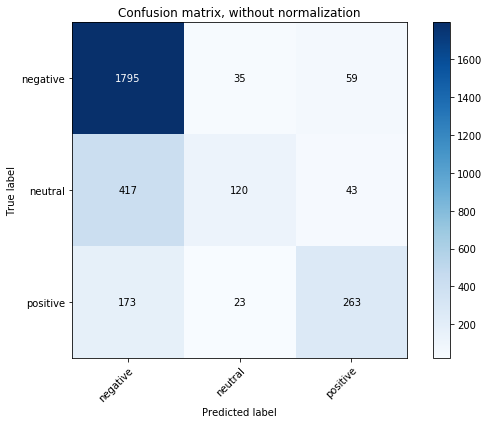

In [42]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, 
                      classes=class_names,
                      title='Confusion matrix, without normalization');

Normalized confusion matrix
[[0.95023822 0.01852832 0.03123346]
 [0.71896552 0.20689655 0.07413793]
 [0.37690632 0.05010893 0.57298475]]


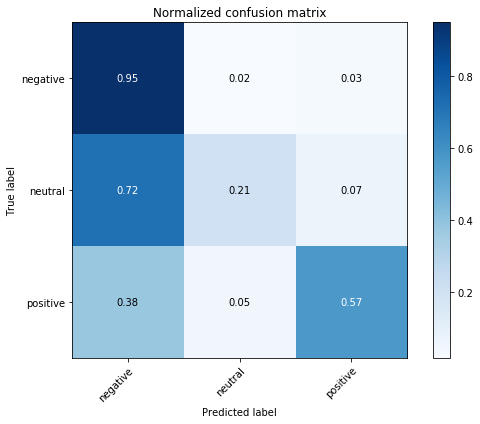

In [43]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

In [44]:
print("classification report:")
print(classification_report(y_test, y_pred,
                            #average='micro',
                            target_names=class_names))

classification report:
              precision    recall  f1-score   support

    negative       0.75      0.95      0.84      1889
     neutral       0.67      0.21      0.32       580
    positive       0.72      0.57      0.64       459

   micro avg       0.74      0.74      0.74      2928
   macro avg       0.72      0.58      0.60      2928
weighted avg       0.73      0.74      0.70      2928



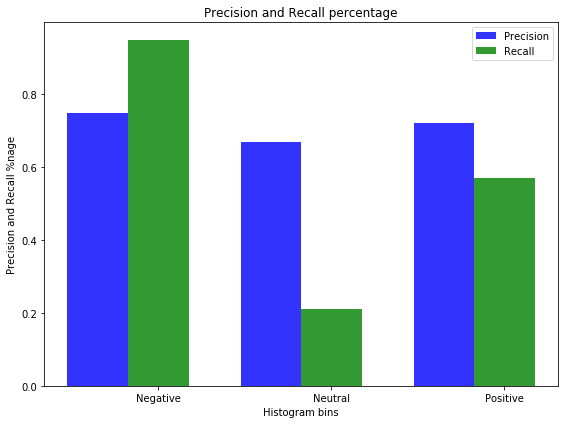

In [45]:
vertical_chart(means_precision = [0.75, 0.67, 0.72],
               means_recall= [0.95, 0.21, 0.57])

### CatBoost modeling

https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb
https://github.com/catboost/tutorials/blob/master/python_tutorial_with_tasks.ipynb
https://github.com/slundberg/shap/issues/367
https://github.com/catboost/catboost-viewer

In [0]:
# fit a CatBoost model to the data
model = CatBoostClassifier(loss_function='MultiClass', 
                           num_boost_round=100, # alias: iterations, n_estimators, num_trees
                           depth=5,
                           learning_rate=0.1, # alias: eta 
                           random_seed=42,
                           task_type='GPU'
                           )

In [47]:
# train catboost model on training dataset
model.fit(X_train, y_train, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: -1.0431315	total: 17.3ms	remaining: 1.72s
1:	learn: -0.9985919	total: 29.9ms	remaining: 1.46s
2:	learn: -0.9658160	total: 41ms	remaining: 1.33s
3:	learn: -0.9357315	total: 54ms	remaining: 1.3s
4:	learn: -0.9113169	total: 69ms	remaining: 1.31s
5:	learn: -0.8910399	total: 80.6ms	remaining: 1.26s
6:	learn: -0.8738991	total: 94ms	remaining: 1.25s
7:	learn: -0.8598400	total: 107ms	remaining: 1.23s
8:	learn: -0.8476287	total: 119ms	remaining: 1.2s
9:	learn: -0.8368954	total: 130ms	remaining: 1.17s
10:	learn: -0.8276511	total: 143ms	remaining: 1.15s
11:	learn: -0.8197621	total: 154ms	remaining: 1.13s
12:	learn: -0.8134103	total: 166ms	remaining: 1.11s
13:	learn: -0.8072390	total: 178ms	remaining: 1.09s
14:	learn: -0.8014916	total: 189ms	remaining: 1.07s
15:	learn: -0.7964417	total: 201ms	remaining: 1.05s
16:	learn: -0.7916426	total: 213ms	remaining: 1.04s
17:	learn: -0.7871098	total: 232ms	remaining: 1.06s
18:	learn: -0.7827116	total: 243ms	remaining: 1.03s
19:	learn: -0.7784074	tot

In [0]:
# Get predicted classes
y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[1807   29   53]
 [ 444   93   43]
 [ 187   21  251]]


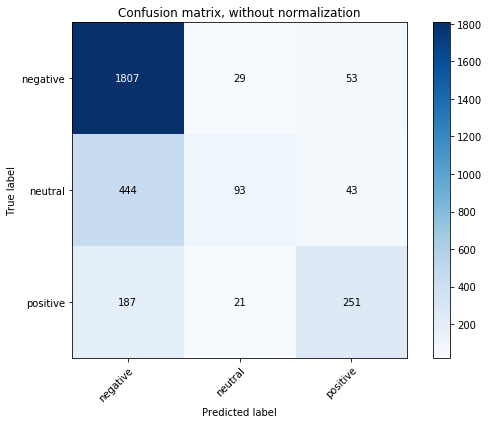

In [49]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization');

Normalized confusion matrix
[[0.95659079 0.01535204 0.02805717]
 [0.76551724 0.16034483 0.07413793]
 [0.40740741 0.04575163 0.54684096]]


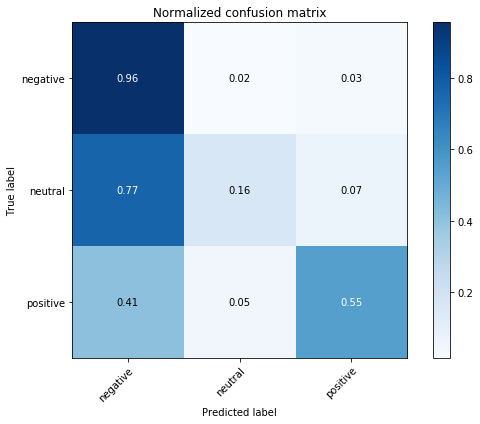

In [50]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, 
                      classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [51]:
print("classification report:")
print(classification_report(y_test, y_pred,
                            target_names=class_names))

classification report:
              precision    recall  f1-score   support

    negative       0.74      0.96      0.84      1889
     neutral       0.65      0.16      0.26       580
    positive       0.72      0.55      0.62       459

   micro avg       0.73      0.73      0.73      2928
   macro avg       0.70      0.55      0.57      2928
weighted avg       0.72      0.73      0.69      2928



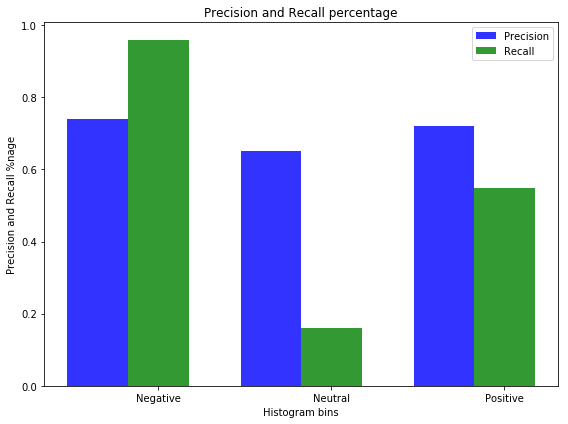

In [52]:
vertical_chart(means_precision = [0.74, 0.65, 0.72], 
                   means_recall= [0.96, 0.16, 0.55])

In [0]:
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_test)

In [0]:
# Get predicted RawFormulaVal
preds_raw = model.predict(X_test, 
                          prediction_type='RawFormulaVal')

### Shap interpretation of Catboost model

In [53]:
# calculate shap values for multiclass.
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/catboost/core.py:1697: UserWarning: 'fstr_type' parameter will be deprecated soon, use 'type' parameter instead
  warnings.warn("'fstr_type' parameter will be deprecated soon, use 'type' parameter instead")


In [0]:
# visualize the first prediction's explanation (in log-odds scale) 
# use matplotlib=True to avoid Javascript
#shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test[0,:], show=True)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, show=True)

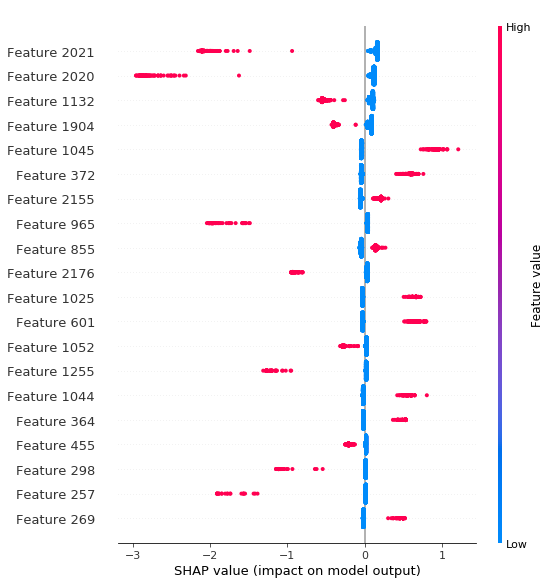

In [54]:
# Summary plot of SHAP values for formula raw predictions for class 0.
shap.summary_plot(shap_values[0], X_test)

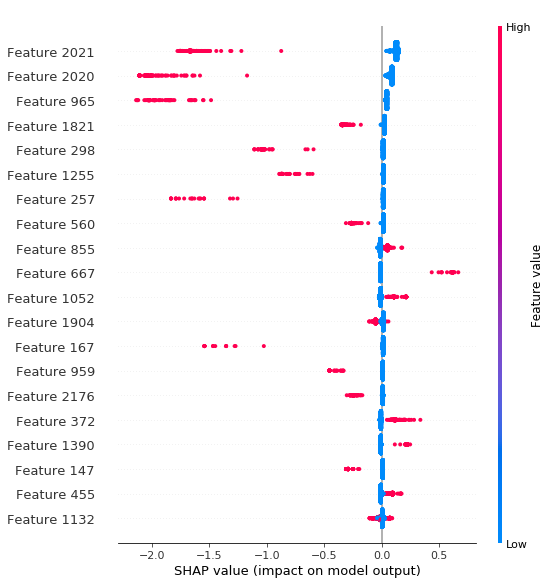

In [55]:
# And force plot for class 1.
shap.summary_plot(shap_values[1], X_test)

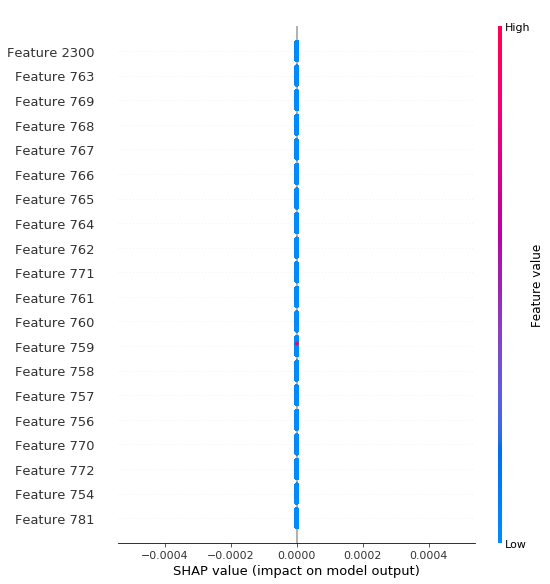

In [56]:
# And force plot for class 2.
shap.summary_plot(shap_values[2], X_test)

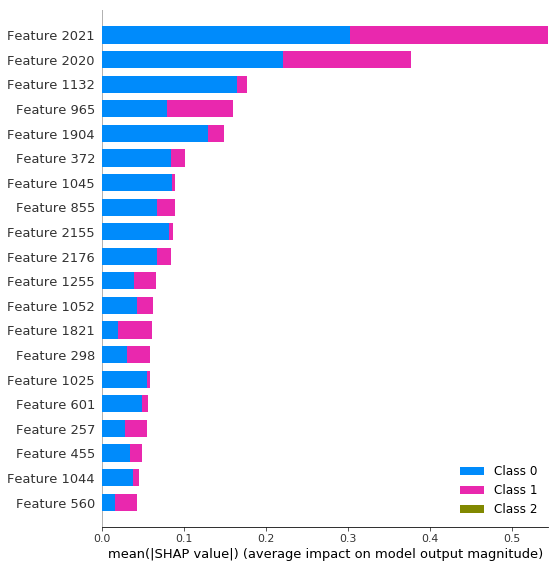

In [57]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

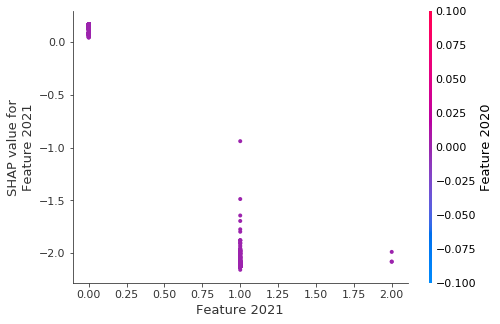

In [58]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Feature 2021", shap_values[0], X_test)

### LightGBM modelling

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

https://www.kaggle.com/georsara1/light-gbm-solution-for-credit-fraud-detection

In [0]:
# fit a LightGBM model to the data
model = LGBMClassifier(objective='multiclass', 
                       boosting_type='gbdt',
                       n_estimators=100,
                       max_depth=5, # -1 means no limit
                       learning_rate=0.1,                       
                       random_state=42,
                      )

In [60]:
# train LightGBM model on the training dataset
model.fit(X_train, y_train, 
          #eval_metric='multi_logloss',
          #eval_set=[X_train, y_train]
          #early_stopping_rounds=10
         )

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='multiclass',
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
# get predicted classes
y_pred = model.predict(X_test,
                       #pred_contrib=True
                      )

Confusion matrix, without normalization
[[1795   30   64]
 [ 420  117   43]
 [ 177   19  263]]


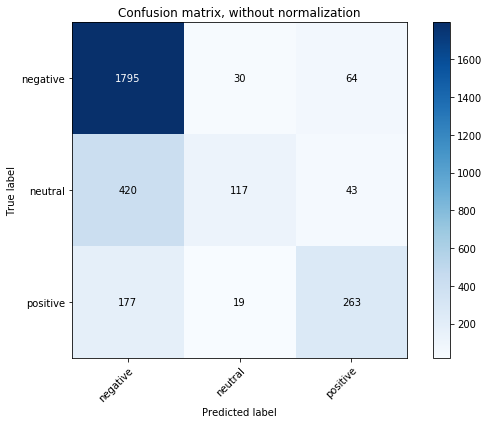

In [62]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, 
                      classes=class_names,
                      title='Confusion matrix, without normalization');

Normalized confusion matrix
[[0.95023822 0.01588142 0.03388036]
 [0.72413793 0.20172414 0.07413793]
 [0.38562092 0.04139434 0.57298475]]


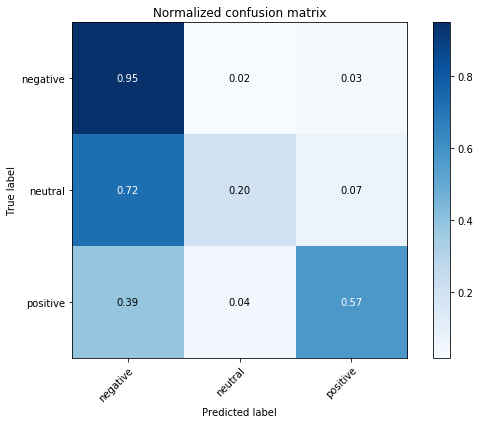

In [63]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, 
                      classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [64]:
print("classification report:")
print(classification_report(y_test, y_pred,
                            target_names=class_names))

classification report:
              precision    recall  f1-score   support

    negative       0.75      0.95      0.84      1889
     neutral       0.70      0.20      0.31       580
    positive       0.71      0.57      0.63       459

   micro avg       0.74      0.74      0.74      2928
   macro avg       0.72      0.57      0.60      2928
weighted avg       0.74      0.74      0.70      2928



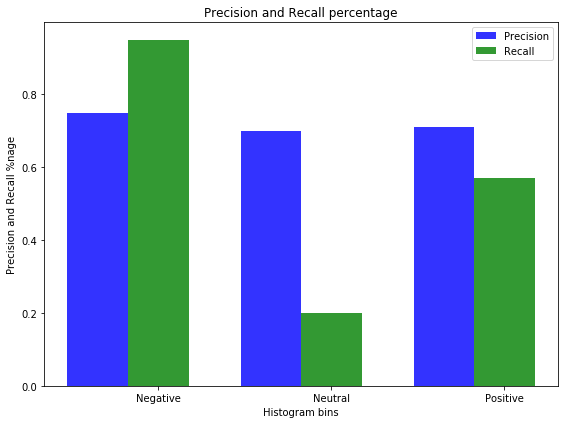

In [65]:
vertical_chart(means_precision = [0.75, 0.70, 0.71], 
                   means_recall= [0.95, 0.20, 0.57])

In [0]:
# additional plots diagram
plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

plot_importance(model)
plt.rcParams['figure.figsize'] = [2, 5]
plt.show()

### Shap interpretation of LightGBM model

In [0]:
# Tree on LightGBM
explainer = shap.TreeExplainer(model)
shap_values_test  = explainer.shap_values(X_test)
#shap_values_train = explainer.shap_values(X_train)

In [0]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_shap_XGB_test)

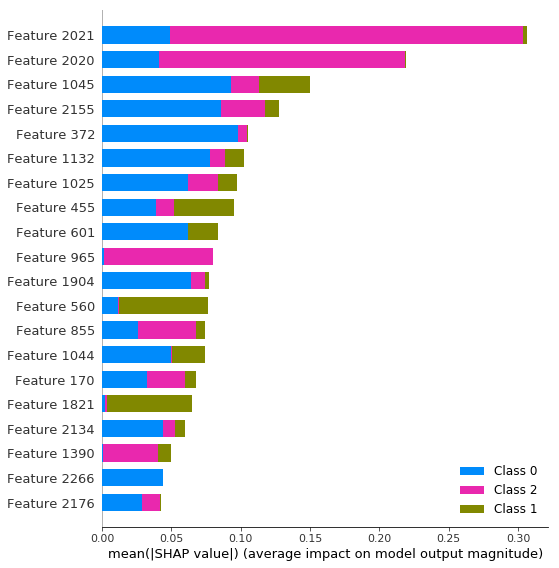

In [67]:
# summarize the effects of all the features
shap.summary_plot(shap_values_test, X_test, plot_type="bar")

In [0]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, show=True)
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test, show=True)

In [0]:
#shap.force_plot(explainer, explainer.expected_value, shap_values, X_test)
#shap.force_plot(explainer, shap_values[0][0], X_test)
#shap.force_plot(explainer, shap_values.expected_value[0][0,:], X_test[0,:])

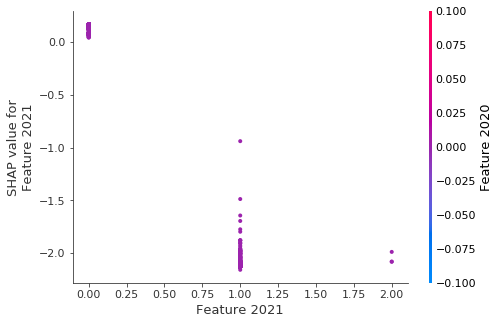

In [68]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Feature 2021", shap_values[0], X_test)

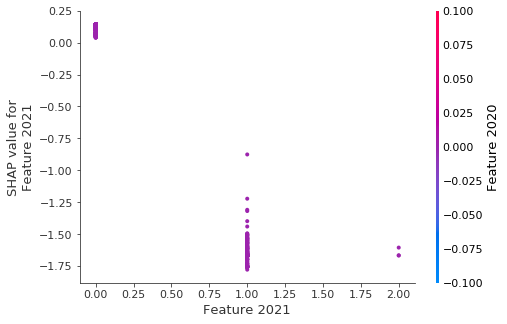

In [69]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Feature 2021", shap_values[1], X_test)

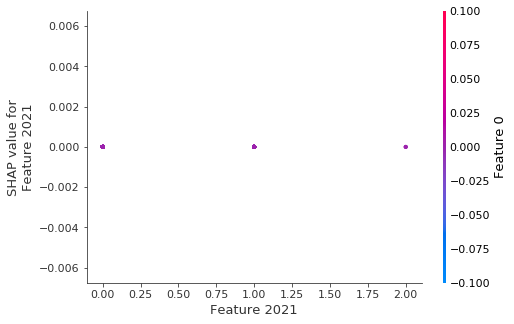

In [70]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Feature 2021", shap_values[2], X_test)

In [0]:
explainer.shap_interaction_values(X_test)

##  Bayesian Optimization and HyperBand

HpBandSter (HyperBand on STERoids)

https://github.com/automl/HpBandSter/blob/master/hpbandster/examples/example_5_keras_worker.py

https://github.com/automl/HpBandSter/blob/master/hpbandster/examples/example_5_keras_worker.py#L168

In [71]:
pip install hpbandster

     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 92kB 14.5MB/s 
     |████████████████████████████████| 890kB 18.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/9d/57/62/6b00c8011bac96e0c404adc5be4e16964ba4544614240b4e23
  Stored in directory: /root/.cache/pip/wheels/75/83/cb/28dd42bac69c8867d485138030daa83841c7f84afe68b2fdf7
Successfully built hpbandster ConfigSpace


In [0]:
import hpbandster.core.result as hpres
import hpbandster.visualization as hpvis

In [0]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

from hpbandster.core.worker import Worker

In [0]:
class XGBoostWorker(Worker):
  def __init__(self, x_train, y_train, x_test, y_test, **kwargs):
    super().__init__(**kwargs)

    self.num_classes = len(np.unique(y_train))
    self.x_test = x_test
    
    self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(x_train,
                                                                          y_train,
                                                                          test_size=0.2,
                                                                          random_state=42,
                                                                         )
    # encode class values as integers
    encoder = LabelEncoder()
    
    encoded_train = encoder.fit_transform(self.y_train)
    encoded_test  = encoder.transform(y_test)
    encoded_val   = encoder.transform(self.y_val)

    # convert to one hot encoded
    self.y_train = to_categorical(encoded_train, 
                                     num_classes=self.num_classes)
    
    self.y_test = to_categorical(encoded_test, 
                                 num_classes=self.num_classes)
    
    self.y_val = to_categorical(encoded_val, 
                                num_classes=self.num_classes)
   
    
    
  def compute(self, config, budget, working_directory, *args, **kwargs):
    """
		Simple example for a compute function using a feed forward network.
		It is trained on the MNIST dataset.
		The input parameter "config" (dictionary) contains the sampled configurations passed by the bohb optimizer
		"""
    
    params = {'objective': 'multi:softmax', 
              'num_class': 3,
              'learning_rate': config['learning_rate'],  
              'n_estimators':  config['n_estimators'],
              'max_depth':     config['max_depth'],
              'gamma': 10,
              'verbose': True
             }
    
    dtrain = xgb.DMatrix(self.x_train, label=self.y_train)
    dtest  = xgb.DMatrix(self.x_test,  label=self.y_test)
    dval   = xgb.DMatrix(self.x_val,   label=self.y_val)

    model  = xgb.train(params, dtrain, int(budget))    
    
    predicitons = model.predict(dval)
    labels = self.y_val
    
    # invert encoding
    labels = np.argmax(labels,axis=1)
    
    score = f1_scores(labels, predicitons)
    
    train_score = model.eval(dtrain)
    val_score   = model.eval(dtest)
    test_score  = model.eval(dtest)

    return ({
			'loss': 1-float(score), 
			'info': {	'test accuracy': test_score[1],
						'train accuracy':    train_score[1],
						'validation accuracy': val_score[1],
						#'number of parameters': model.count_params(),
					}	
		})
  
  @staticmethod
  def get_configspace():
    """
		It builds the configuration space with the needed hyperparameters.
		It is easily possible to implement different types of hyperparameters.
		Beside float-hyperparameters on a log scale, it is also able to handle categorical input parameter.
		:return: ConfigurationsSpace-Object
		"""
    cs = CS.ConfigurationSpace()
    
    learning_rate = CSH.UniformFloatHyperparameter('learning_rate', lower=1e-6, 
                                                   upper=1e-1, default_value='1e-2', 
                                                   log=True)
    
    cs.add_hyperparameters([learning_rate])
    
    n_estimators =  CSH.UniformIntegerHyperparameter('n_estimators', lower=50, upper=200, 
                                                     default_value=50)
    
    max_depth    =  CSH.UniformIntegerHyperparameter('max_depth', lower=1, upper=5, 
                                                     default_value=2)
   
    cs.add_hyperparameters([n_estimators, max_depth])
    
    return cs

In [0]:
worker = XGBoostWorker(X_train, y_train, X_test, y_test, run_id='0')
cs = worker.get_configspace()

In [76]:
config = cs.sample_configuration().get_dictionary()
print(config)

{'learning_rate': 0.0009904150174513309, 'max_depth': 5, 'n_estimators': 99}


In [77]:
res = worker.compute(config=config, budget=3, working_directory='.')
print(res)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'loss': 0.5363110067186179, 'info': {'test accuracy': '0', 'train accuracy': '0', 'validation accuracy': '0'}}


### Alternative methods: Bayesian Hyperparameter Optimization  

- http://krasserm.github.io/2018/03/21/bayesian-optimization/
- https://github.com/fmfn/BayesianOptimization

## Develop a Deep Convolutional Neural Network for Sentiment Analysis (Text Classification)

We will employ Word Embeddings techniques for representing text where different words with similar meaning have a similar real-valued vector representation.

https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [0]:
data = airline_tweets[['text','airline_sentiment']]

In [0]:
features = data['text'].values  
labels   = data['airline_sentiment'].values 

In [0]:
processed_features = []

for sentence in range(0, len(features)):  
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    
    processed_features.append(processed_feature)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(np.array(processed_features),
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=42)  

The next step is to encode each document as a sequence of integers. We then train it on all documents in the training dataset to vocabulary of all tokens in the training dataset and develops a consistent mapping from words in the vocabulary to unique integers. 

In [0]:
# Tokenize words (max words, max_review_len)
max_fatures = 300 #2500

# create the tokenizer
tokenizer = Tokenizer(lower = True, 
                      num_words=max_fatures, 
                      split=' ')

# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)

# Vocabulary size: Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 #input_dim (for Embedding layer)

In [0]:
# Tokenize words: data preprocessing (sequence encode)
train_tokenized_features = tokenizer.texts_to_sequences(X_train)
test_tokenized_features  = tokenizer.texts_to_sequences(X_test)

# Pad sequences with zeros
X_train_tokenized = pad_sequences(train_tokenized_features,
                                  maxlen=max_fatures, #None
                                  dtype='int32', 
                                  padding='pre', 
                                  truncating='pre',
                                  value=0.0)

X_test_tokenized = pad_sequences(test_tokenized_features, 
                                 maxlen=max_fatures, #None
                                 dtype='int32', 
                                 padding='pre',
                                 truncating='pre', 
                                 value=0.0)

Reviews that have more than 80 words are truncated to exactly 80 words in length by removing excess words from the beginning of the review.  Any review that has fewer than 80 words is padded up to exactly 80 words by adding 0 values to the beginning of the review.

We can remove excess words from the end of reviews by specifying truncating='post'. And we can pad at the end of reviews by specifying padding='post'

In [0]:
# store category class labels and number of labels 
class_names = np.unique(y_train)
num_classes = len(class_names)

In [0]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)

# digitize categorical label data
y_train_encoded = encoder.transform(y_train)
y_test_encoded  = encoder.transform(y_test)

# one hot encode
y_train_ohe = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_ohe  = to_categorical(y_test_encoded,  num_classes=num_classes)

Although it is possible to feed integer-encoded sentences directly to an LSTM network, better results are obtained by converting each integer ID into a vector of real values. For example, the word "the" has index value 4 but will be converted to a vector like (0.1234, 0.5678, . . 0.3572). This is called a word embedding.

The idea is to construct vectors so that similar words, such as "man" and "male," have vectors that are numerically close. The length of the vector must be determined by trial and error. The demo uses size 32 but for most problems a vector size of 100 to 500 is more common.

In [0]:
# Define model
def create_model(input_dim, output_dim=300, input_length=300, lstm_out=100):
  '''
  create model: #max_fatures,embed_dim, input_length
  '''
  model = Sequential()
  
  model.add(Embedding(input_dim=input_dim, # size of the vocabulary in the text data
                      output_dim=output_dim, # size of the vector space in which words will be embedded
                      input_length=input_length, # length of input sequences,
                      embeddings_initializer='uniform',
                     ))
  model.add(Dropout(0.2)) # layer-wise dropout (try 0.5)
  model.add(LSTM(lstm_out, 
                 dropout=0.2, # input dropout (gate-specific dropout) 
                 recurrent_dropout=0.2 # recurrent dropout connections (gate-specific dropout)
                )
           )
  model.add(Dropout(0.2)) # layer-wise dropout
  model.add(Dense(3, activation='softmax'))

  print(model.summary())

  model.compile(loss = 'categorical_crossentropy', 
                optimizer='adam',
               )
  return model

In [87]:
# create lstm model model
model = create_model(input_dim=vocab_size, input_length=X_train_tokenized.shape[1])

Instructions for updating:
Colocations handled automatically by placer.


13:15:07 From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


13:15:07 From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          3991500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 4,152,203
Trainable params: 4,152,203
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
%%time
# train LSTM model on training dataset
history = model.fit(X_train_tokenized, 
                    y_train_ohe,  
                    validation_split=0.2,
                    epochs=10, 
                    batch_size=512,
                   )

Instructions for updating:
Use tf.cast instead.


13:15:09 From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 20s 2ms/step - loss: 0.9469 - val_loss: 0.8020
Epoch 2/10
9369/9369 [==============================] - 17s 2ms/step - loss: 0.7541 - val_loss: 0.7239
Epoch 3/10
9369/9369 [==============================] - 17s 2ms/step - loss: 0.6658 - val_loss: 0.6625
Epoch 4/10
9369/9369 [==============================] - 17s 2ms/step - loss: 0.6068 - val_loss: 0.6166
Epoch 5/10
9369/9369 [==============================] - 17s 2ms/step - loss: 0.5637 - val_loss: 0.5982
Epoch 6/10
9369/9369 [==============================] - 17s 2ms/step - loss: 0.5427 - val_loss: 0.5864
Epoch 7/10
9369/9369 [==============================] - 17s 2ms/step - loss: 0.5396 - val_loss: 0.5946
Epoch 8/10
9369/9369 [==============================] - 17s 2ms/step - loss: 0.5293 - val_loss: 0.5917
Epoch 9/10
9369/9369 [==============================] - 17s 2ms/step - loss: 0.5258 - val_loss: 0.5906
Epoch 10/10
9369/9369 [==

In [0]:
# make model prediction
y_pred = model.predict(X_test_tokenized)

In [0]:
# invert one-hot-encoded model class predicitons 
y_pred = np.argmax(y_pred, axis=1) 

13:18:33 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb68dc6a0>
13:18:33 Using auto colorbar locator on colorbar
13:18:33 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb68dc6a0>
13:18:33 Setting pcolormesh
13:18:33 update_title_pos
13:18:33 update_title_pos
13:18:33 update_title_pos
13:18:33 update_title_pos


Confusion matrix, without normalization
[[1643  169   77]
 [ 202  313   65]
 [ 101   66  292]]


13:18:33 update_title_pos
13:18:33 update_title_pos
13:18:33 update_title_pos
13:18:33 update_title_pos
13:18:33 update_title_pos
13:18:33 update_title_pos


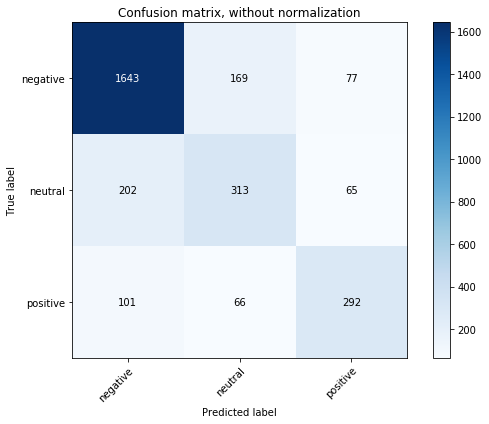

In [91]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names,
                      title='Confusion matrix, without normalization');

13:18:36 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb68ad470>
13:18:36 Using auto colorbar locator on colorbar
13:18:36 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb68ad470>
13:18:36 Setting pcolormesh
13:18:36 update_title_pos
13:18:36 update_title_pos


Normalized confusion matrix
[[0.86977237 0.08946533 0.04076231]
 [0.34827586 0.53965517 0.11206897]
 [0.22004357 0.14379085 0.63616558]]


13:18:36 update_title_pos
13:18:36 update_title_pos
13:18:36 update_title_pos
13:18:36 update_title_pos
13:18:36 update_title_pos
13:18:36 update_title_pos
13:18:36 update_title_pos
13:18:36 update_title_pos


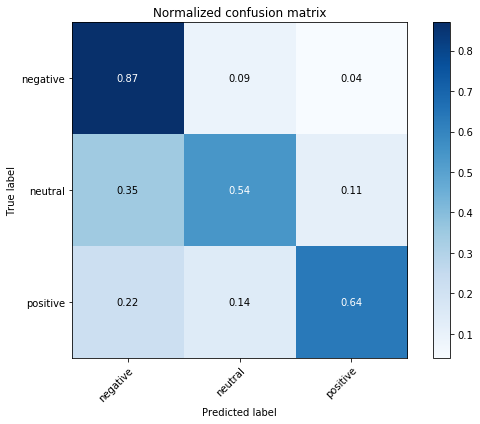

In [92]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

In [93]:
print("classification report:")
print(classification_report(y_test_encoded, y_pred,
                            target_names=class_names,
                           ))

classification report:
              precision    recall  f1-score   support

    negative       0.84      0.87      0.86      1889
     neutral       0.57      0.54      0.55       580
    positive       0.67      0.64      0.65       459

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.70      0.68      0.69      2928
weighted avg       0.76      0.77      0.77      2928



13:19:11 update_title_pos
13:19:12 update_title_pos
13:19:12 update_title_pos
13:19:12 update_title_pos
13:19:12 update_title_pos


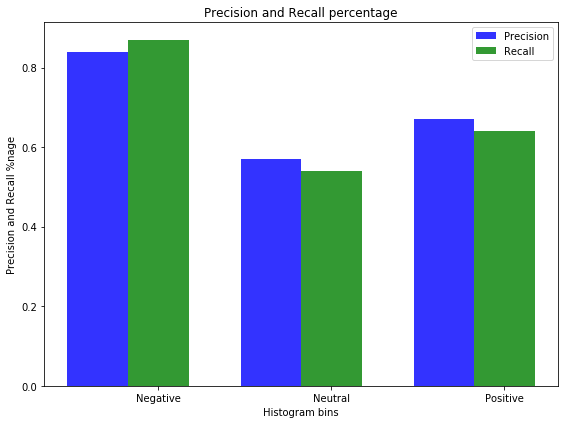

In [94]:
vertical_chart(means_precision  = [0.84, 0.57, 0.67], 
                   means_recall = [0.87, 0.54, 0.64])

### LSTM and Convolutional Neural Network For Sequence Classification

Convolutional neural networks excel at learning the spatial structure in input data.

The ariline review data does have a one-dimensional spatial structure in the sequence of words in reviews and the CNN may be able to pick out invariant features for good and bad sentiment. This learned spatial features may then be learned as sequences by an LSTM layer.

We can easily add a one-dimensional CNN and max pooling layers after the Embedding layer which then feed the consolidated features to the LSTM. We can use a smallish set of 32 features with a small filter length of 3. The pooling layer can use the standard length of 2 to halve the feature map size.

In [0]:
def create_cnn_lstm(input_dim,output_dim=300,input_length=300,lstm_out=100): 
  #num_filters, embedding_dim, maxlen; kernel_size, vocab_size,
  '''
  Source: 
  - https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
  - https://realpython.com/python-keras-text-classification/
  '''
  # Embedding
  #max_features = 2500
  #maxlen = 100 #max_review_length/input_length
  #embedding_size = 128 #embedding_vecor_length/output_dim
  
  # values per word
  #embedding_vecor_length = 32 #output_dim
  
  # truncate and pad input sequences
  #max_review_length = 80 #500

  #top_words = 80 #5000 #max_features
  
  # Convolution
  kernel_size = 5
  filters = 64
  pool_size = 4
  
  # LSTM output size
  #lstm_output_size = 100
  
  model = Sequential()
  
  model.add(Embedding(input_dim=input_dim, # size of the vocabulary
                      output_dim=output_dim, # size of the dense vector
                      input_length=input_length # length of the sequence
                     ))
  model.add(Dropout(0.25))
  model.add(Conv1D(filters=filters, 
                   kernel_size=kernel_size, 
                   padding='same', 
                   activation='relu',
                   strides=1,
                  ))
  model.add(MaxPooling1D(pool_size=pool_size))
  #model.add(layers.GlobalMaxPooling1D())
  model.add(LSTM(units=lstm_out))
  model.add(Dense(3, activation='softmax'))

  print(model.summary())

  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
               )

  return model

Our input is a sequence of words (technically, integer word IDs) of maximum length = max_words, and our output is a multi-class sentiment label (0, 1, or 2).

In [96]:
# create lstm+cnn model model
model = create_cnn_lstm(input_dim=vocab_size, input_length=X_train_tokenized.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          3991500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 64)           96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 4,153,867
Trainable params: 4,153,867
Non-trainable params: 0
_________________________________________________________________


In [97]:
# train lstm model with a convolutional layer
history = model.fit(X_train_tokenized, 
                    y_train_ohe,  
                    validation_split=0.2,
                    epochs=10, 
                    batch_size=512,
                   )

Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 9s 1ms/step - loss: 0.9497 - val_loss: 0.8767
Epoch 2/10
9369/9369 [==============================] - 6s 620us/step - loss: 0.8036 - val_loss: 0.7483
Epoch 3/10
9369/9369 [==============================] - 6s 623us/step - loss: 0.6803 - val_loss: 0.6634
Epoch 4/10
9369/9369 [==============================] - 6s 624us/step - loss: 0.5788 - val_loss: 0.6041
Epoch 5/10
9369/9369 [==============================] - 6s 626us/step - loss: 0.5357 - val_loss: 0.5975
Epoch 6/10
9369/9369 [==============================] - 6s 625us/step - loss: 0.5179 - val_loss: 0.5857
Epoch 7/10
9369/9369 [==============================] - 6s 621us/step - loss: 0.5009 - val_loss: 0.5928
Epoch 8/10
9369/9369 [==============================] - 6s 624us/step - loss: 0.4902 - val_loss: 0.5921
Epoch 9/10
9369/9369 [==============================] - 6s 621us/step - loss: 0.4794 - val_loss: 0.5980
Epoch 10/10
9369/9

In [0]:
# make model prediction
y_pred = model.predict(X_test_tokenized)

In [0]:
# invert one-hot-encoded model class predicitons 
y_pred = np.argmax(y_pred, axis=1) 

13:21:00 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb5a19be0>
13:21:00 Using auto colorbar locator on colorbar
13:21:00 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb5a19be0>
13:21:00 Setting pcolormesh
13:21:00 update_title_pos
13:21:00 update_title_pos
13:21:00 update_title_pos
13:21:00 update_title_pos


Confusion matrix, without normalization
[[1638  173   78]
 [ 190  340   50]
 [  96   79  284]]


13:21:00 update_title_pos
13:21:00 update_title_pos
13:21:00 update_title_pos
13:21:00 update_title_pos
13:21:00 update_title_pos
13:21:00 update_title_pos


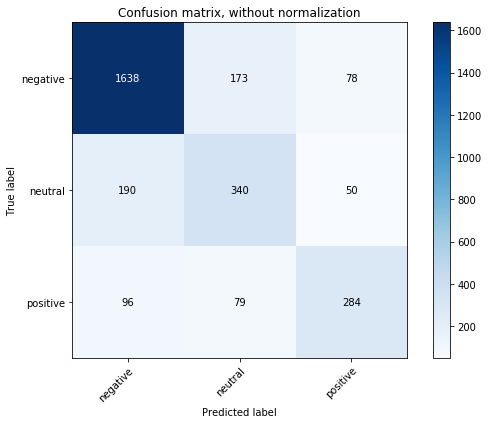

In [100]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names,
                      title='Confusion matrix, without normalization');

13:21:00 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb59f3cc0>
13:21:00 Using auto colorbar locator on colorbar
13:21:00 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb59f3cc0>
13:21:00 Setting pcolormesh
13:21:01 update_title_pos
13:21:01 update_title_pos


Normalized confusion matrix
[[0.86712546 0.09158285 0.04129169]
 [0.32758621 0.5862069  0.0862069 ]
 [0.20915033 0.17211329 0.61873638]]


13:21:01 update_title_pos
13:21:01 update_title_pos
13:21:01 update_title_pos
13:21:01 update_title_pos
13:21:01 update_title_pos
13:21:01 update_title_pos
13:21:01 update_title_pos
13:21:01 update_title_pos


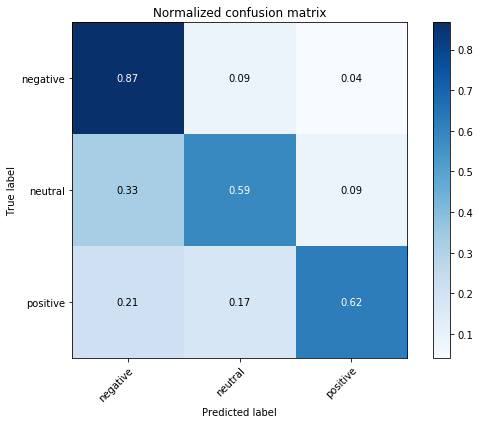

In [101]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

In [102]:
print("classification report:")
print(classification_report(y_test_encoded, y_pred,
                            target_names=class_names,
                           ))

classification report:
              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      1889
     neutral       0.57      0.59      0.58       580
    positive       0.69      0.62      0.65       459

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.70      0.69      0.70      2928
weighted avg       0.77      0.77      0.77      2928



13:21:31 update_title_pos
13:21:31 update_title_pos
13:21:31 update_title_pos
13:21:31 update_title_pos
13:21:31 update_title_pos


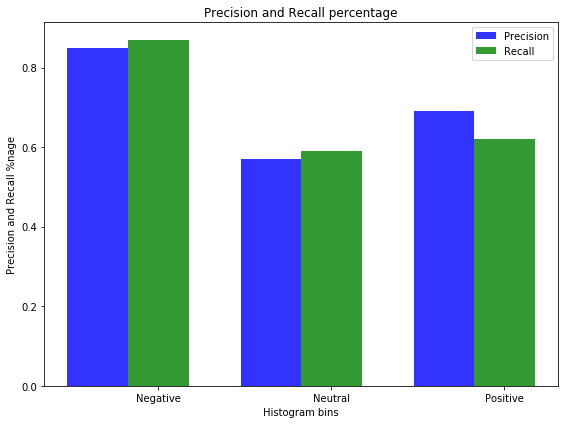

In [103]:
vertical_chart(means_precision  = [0.85, 0.57, 0.69], 
               means_recall = [0.87, 0.59, 0.62])

In [0]:
def build_estimator(input_dim,output_dim=300,input_length=300,lstm_out=100):#max_words,embed_vec_len
  # Set up the way in which the LSTM weights and biases will be initialized
  e_init = K.initializers.RandomUniform(-0.01, 0.01, seed=1)
  init   = K.initializers.glorot_uniform(seed=1)

  # values per word
  #embed_vec_len = 32  
  
  model = Sequential()
  
  model.add(Embedding(input_dim=input_dim, # size of the vocabulary
                      output_dim=output_dim, # size of the dense vector
                      input_length=input_length, # length of the sequence
                      embeddings_initializer=e_init, 
                      mask_zero=True))
  model.add(Dropout(0.5))
  model.add(LSTM(units=100, 
                 kernel_initializer=init,
                 dropout=0.2, 
                 recurrent_dropout=0.2))  # 100 memory
  model.add(Dense(units=3, 
                  kernel_initializer=init,
                  activation='softmax'))
  
  print(model.summary())

  model.compile(loss = 'categorical_crossentropy', 
                optimizer='adam',
               )
  return model

In [105]:
# create lstm model model
model = build_estimator(input_dim=vocab_size, input_length=X_train_tokenized.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          3991500   
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 4,152,203
Trainable params: 4,152,203
Non-trainable params: 0
_________________________________________________________________
None


In [106]:
# train lstm model with dropout and weight initialization
history = model.fit(X_train_tokenized, 
                    y_train_ohe,  
                    validation_split=0.2,
                    epochs=10, 
                    batch_size=512,
                   )

Train on 9369 samples, validate on 2343 samples
Epoch 1/10
9369/9369 [==============================] - 23s 2ms/step - loss: 0.9388 - val_loss: 0.8013
Epoch 2/10
9369/9369 [==============================] - 21s 2ms/step - loss: 0.7493 - val_loss: 0.7019
Epoch 3/10
9369/9369 [==============================] - 21s 2ms/step - loss: 0.6508 - val_loss: 0.6530
Epoch 4/10
9369/9369 [==============================] - 21s 2ms/step - loss: 0.5924 - val_loss: 0.6136
Epoch 5/10
9369/9369 [==============================] - 21s 2ms/step - loss: 0.5583 - val_loss: 0.5915
Epoch 6/10
9369/9369 [==============================] - 21s 2ms/step - loss: 0.5412 - val_loss: 0.5932
Epoch 7/10
9369/9369 [==============================] - 21s 2ms/step - loss: 0.5358 - val_loss: 0.5944
Epoch 8/10
9369/9369 [==============================] - 21s 2ms/step - loss: 0.5320 - val_loss: 0.5874
Epoch 9/10
9369/9369 [==============================] - 21s 2ms/step - loss: 0.5260 - val_loss: 0.5847
Epoch 10/10
9369/9369 [==

In [0]:
# make model prediction
y_pred = model.predict(X_test_tokenized)

In [0]:
# invert one-hot-encoded model class predicitons 
y_pred = np.argmax(y_pred, axis=1) 

13:26:19 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb47cd828>
13:26:19 Using auto colorbar locator on colorbar
13:26:19 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb47cd828>
13:26:19 Setting pcolormesh
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos


Confusion matrix, without normalization
[[1697  123   69]
 [ 241  273   66]
 [ 108   59  292]]


13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos


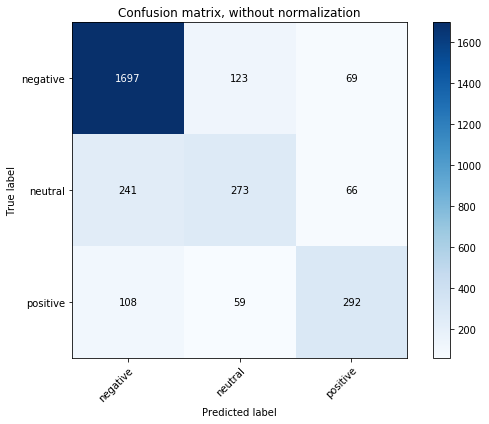

In [109]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names,
                      title='Confusion matrix, without normalization');

13:26:19 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb47349b0>
13:26:19 Using auto colorbar locator on colorbar
13:26:19 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb47349b0>
13:26:19 Setting pcolormesh
13:26:19 update_title_pos
13:26:19 update_title_pos


Normalized confusion matrix
[[0.89835892 0.06511382 0.03652726]
 [0.41551724 0.47068966 0.1137931 ]
 [0.23529412 0.12854031 0.63616558]]


13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos
13:26:19 update_title_pos


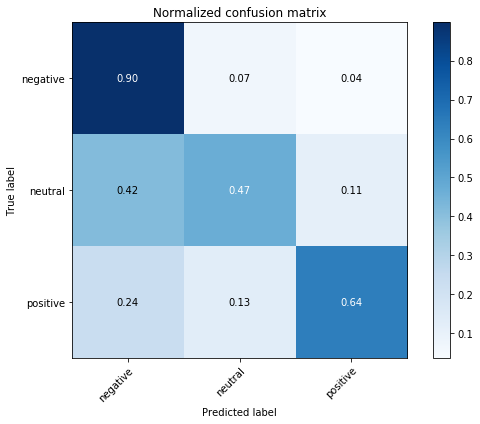

In [110]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

In [111]:
print("classification report:")
print(classification_report(y_test_encoded, y_pred,
                            target_names=class_names,
                           ))

classification report:
              precision    recall  f1-score   support

    negative       0.83      0.90      0.86      1889
     neutral       0.60      0.47      0.53       580
    positive       0.68      0.64      0.66       459

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.70      0.67      0.68      2928
weighted avg       0.76      0.77      0.76      2928



13:28:00 update_title_pos
13:28:00 update_title_pos
13:28:00 update_title_pos
13:28:00 update_title_pos
13:28:00 update_title_pos


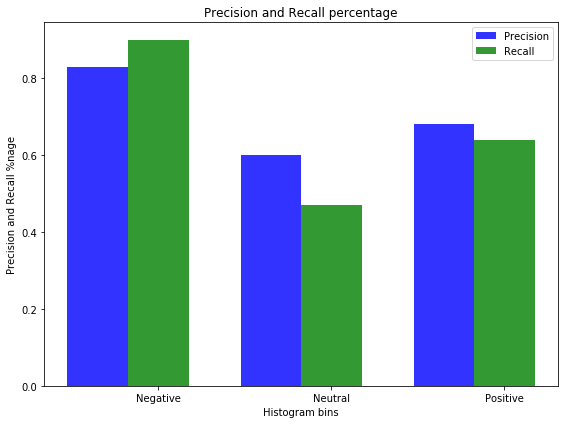

In [112]:
vertical_chart(means_precision  = [0.83, 0.60, 0.68], 
               means_recall = [0.90, 0.47, 0.64])

source: 

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://medium.com/@panghalarsh/sentiment-analysis-in-python-using-keras-glove-twitter-word-embeddings-and-deep-rnn-on-a-combined-580646cb900a

In [0]:
# Build deep recurrent neural network that contains an Embedding layer, Bidirectional LSTM
def build_model(input_dim=30001,lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, 
                kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, 
                conv_size=32):

    max_len = 300 #80
    embed_size = 300 #128
    
    inp = Input(shape = (max_len,))
    
    x = Embedding(input_dim=input_dim, # size of the vocabulary
                  output_dim=embed_size, # size of the dense vector 
                  input_length=max_len,  # length of the sequence
                  trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units=units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', 
                kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', 
                kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', 
                kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', 
                kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(3, activation = "softmax")(x)

    model = Model(inputs = inp, outputs = x)
    
    print(model.summary())
    
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = Adam(lr = lr, decay = lr_d), 
                 )

    return model

In [115]:
# Deep learning model with LSTM, GRU, Spatial Dropout, BatchNormalization layers
model = build_model(input_dim=vocab_size, lr = 1e-3, lr_d = 1e-10, units = 128,
                    spatial_dr = 0.5, kernel_size1=4, kernel_size2=4, 
                    dense_units=64, dr=0.2, conv_size=32)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 300, 300)     3991500     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 300, 300)     0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 300, 256)     329472      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv1d_2 (

In [116]:
%%time
# train deep learning model
history = model.fit(X_train_tokenized, 
                    y_train_ohe,
                    batch_size=128, 
                    epochs=10, 
                    validation_split=0.1, 
                    shuffle=True, 
                    #verbose = 1, 
                    #callbacks = [check_point, early_stop]
                   )

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


13:29:48 From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 10540 samples, validate on 1172 samples
Epoch 1/10
10540/10540 [==============================] - 178s 17ms/step - loss: 0.9878 - val_loss: 0.9967
Epoch 2/10
10540/10540 [==============================] - 174s 17ms/step - loss: 0.8366 - val_loss: 0.8149
Epoch 3/10
10540/10540 [==============================] - 174s 17ms/step - loss: 0.7707 - val_loss: 0.6879
Epoch 4/10
10540/10540 [==============================] - 174s 16ms/step - loss: 0.7323 - val_loss: 0.6746
Epoch 5/10
10540/10540 [==============================] - 173s 16ms/step - loss: 0.7121 - val_loss: 0.6552
Epoch 6/10
10540/10540 [==============================] - 175s 17ms/step - loss: 0.7024 - val_loss: 0.6554
Epoch 7/10
10540/10540 [==============================] - 173s 16ms/step - loss: 0.6778 - val_loss: 0.6476
Epoch 8/10
10540/10540 [==============================] - 172s 16ms/step - loss: 0.6698 - val_loss: 0.6414
Epoch 9/10
10540/10540 [==============================] - 172s 16ms/step - loss: 0.6603 - val_l

In [0]:
# make model prediction
y_pred = model.predict(X_test_tokenized)

In [0]:
# invert one-hot-encoded model class predicitons 
y_pred = np.argmax(y_pred, axis=1) 

14:00:06 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb1133cc0>
14:00:06 Using auto colorbar locator on colorbar
14:00:06 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb1133cc0>
14:00:06 Setting pcolormesh
14:00:06 update_title_pos
14:00:06 update_title_pos
14:00:06 update_title_pos
14:00:06 update_title_pos


Confusion matrix, without normalization
[[1760   93   36]
 [ 305  236   39]
 [ 146   66  247]]


14:00:06 update_title_pos
14:00:06 update_title_pos
14:00:06 update_title_pos
14:00:06 update_title_pos
14:00:06 update_title_pos
14:00:06 update_title_pos


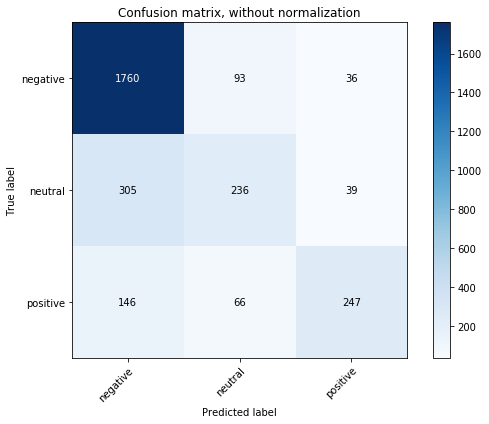

In [119]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names,
                      title='Confusion matrix, without normalization');

14:00:07 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb104f5c0>
14:00:07 Using auto colorbar locator on colorbar
14:00:07 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cb104f5c0>
14:00:07 Setting pcolormesh
14:00:07 update_title_pos
14:00:07 update_title_pos


Normalized confusion matrix
[[0.9317099  0.0492324  0.0190577 ]
 [0.52586207 0.40689655 0.06724138]
 [0.31808279 0.14379085 0.53812636]]


14:00:07 update_title_pos
14:00:07 update_title_pos
14:00:07 update_title_pos
14:00:07 update_title_pos
14:00:07 update_title_pos
14:00:07 update_title_pos
14:00:07 update_title_pos
14:00:07 update_title_pos


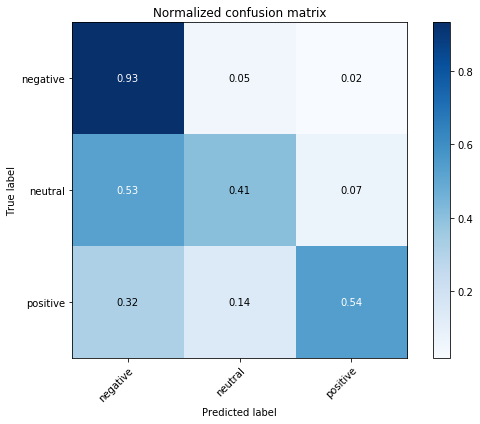

In [120]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

In [121]:
print("classification report:")
print(classification_report(y_test_encoded, y_pred,
                            target_names=class_names,
                           ))

classification report:
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1889
     neutral       0.60      0.41      0.48       580
    positive       0.77      0.54      0.63       459

   micro avg       0.77      0.77      0.77      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.77      0.75      2928



14:00:39 update_title_pos
14:00:39 update_title_pos
14:00:39 update_title_pos
14:00:39 update_title_pos
14:00:39 update_title_pos


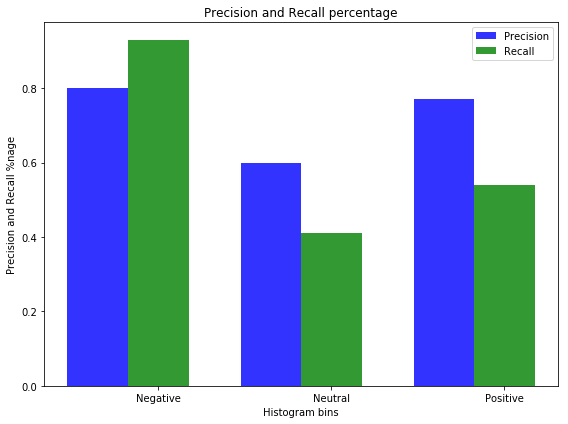

In [122]:
vertical_chart(means_precision  = [0.80, 0.60, 0.77], 
               means_recall = [0.93, 0.41, 0.54])

### Word2Vec implementation provided in the Gensim 

Source: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [123]:
from gensim.models import Word2Vec

14:00:46 {'transport_params': None, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'r', 'uri': '/usr/local/lib/python3.6/dist-packages/smart_open/VERSION'}
14:00:46 'pattern' package not found; tag filters are not available for English


In [124]:
sentences=X_train

# train word2vec model
model = Word2Vec(sentences, size=100, window=5, workers=8, min_count=1)
# summarize vocabulary size in model
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

14:02:43 collecting all words and their counts
14:02:43 Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'numpy.str_'>.
14:02:43 PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
14:02:43 PROGRESS: at sentence #10000, processed 981531 words, keeping 44 word types
14:02:43 collected 46 word types from a corpus of 1150601 raw words and 11712 sentences
14:02:43 Loading a fresh vocabulary
14:02:43 effective_min_count=1 retains 46 unique words (100% of original 46, drops 0)
14:02:43 effective_min_count=1 leaves 1150601 word corpus (100% of original 1150601, drops 0)
14:02:43 deleting the raw counts dictionary of 46 items
14:02:43 sample=0.001 downsamples 24 most-common words
14:02:43 downsampling leaves estimated 209527 word corpus (18.2% of prior 1150601)
14:02:43 estimated required memory for 46 words and 100 dimensions: 59800 bytes
14:02:43 resetting layer weights
14:02:43 training model with 8 workers on 4

Vocabulary size: 46


In [125]:
# pad sequences
max_length = max([len(s.split()) for s in sentences.tolist()])
print(max_length)

33


In [0]:
# encoded_docs
Xtrain = pad_sequences(train_tokenized_features, maxlen=max_length, padding='post')
Xtest  = pad_sequences(test_tokenized_features,  maxlen=max_length, padding='post')

In [0]:
ytrain = y_train_ohe
ytest  = y_test_ohe

In [0]:
# define model
def build_classifier(input_dim, input_length, output_dim=100):
  
  model = Sequential()
  
  model.add(Embedding(input_dim=input_dim, 
                      output_dim=output_dim, 
                      input_length=input_length,
                      embeddings_initializer='uniform',
                     ))
  model.add(Conv1D(filters=32,
                   kernel_size=8, 
                   activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  print(model.summary())

  # compile network
  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                )
  
  return model

In [135]:
# build model
model = build_classifier(input_dim=vocab_size, input_length=max_length)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 33, 100)           1330500   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 26, 32)            25632     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 13, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 416)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                4170      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 33        
Total params: 1,360,335
Trainable params: 1,360,335
Non-trainable params: 0
_________________________________________________________________


In [155]:
# fit network (one-hot-encoded label)
model.fit(Xtrain, ytrain, epochs=10, verbose=1)

Epoch 1/10
11712/11712 [==============================] - 4s 365us/step - loss: 0.7269
Epoch 2/10
11712/11712 [==============================] - 3s 237us/step - loss: 0.6005
Epoch 3/10
11712/11712 [==============================] - 3s 232us/step - loss: 0.5234
Epoch 4/10
11712/11712 [==============================] - 3s 233us/step - loss: 0.4666
Epoch 5/10
11712/11712 [==============================] - 3s 230us/step - loss: 0.4113
Epoch 6/10
11712/11712 [==============================] - 3s 234us/step - loss: 0.3562
Epoch 7/10
11712/11712 [==============================] - 3s 232us/step - loss: 0.2974
Epoch 8/10
11712/11712 [==============================] - 3s 232us/step - loss: 0.2514
Epoch 9/10
11712/11712 [==============================] - 3s 231us/step - loss: 0.2075
Epoch 10/10
11712/11712 [==============================] - 3s 234us/step - loss: 0.1699


In [0]:
# make model prediction
y_pred = model.predict(Xtest)

In [0]:
# invert one-hot-encoded model class predicitons 
y_pred = np.argmax(y_pred, axis=1) 

14:35:30 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cadd344a8>
14:35:30 Using auto colorbar locator on colorbar
14:35:30 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cadd344a8>
14:35:30 Setting pcolormesh
14:35:30 update_title_pos
14:35:30 update_title_pos
14:35:30 update_title_pos
14:35:30 update_title_pos
14:35:30 update_title_pos


Confusion matrix, without normalization
[[1637  183   69]
 [ 221  305   54]
 [ 112   82  265]]


14:35:30 update_title_pos
14:35:30 update_title_pos
14:35:30 update_title_pos
14:35:30 update_title_pos
14:35:30 update_title_pos


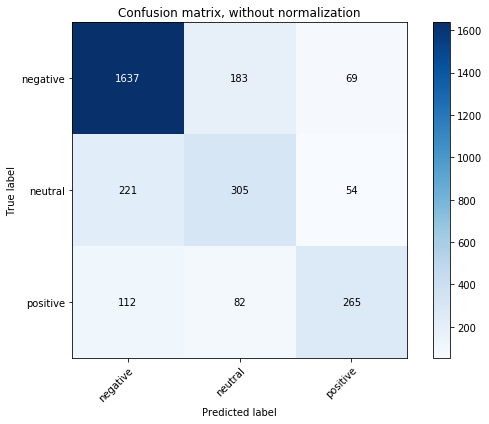

In [160]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names,
                      title='Confusion matrix, without normalization');

14:35:32 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cadcc72e8>
14:35:32 Using auto colorbar locator on colorbar
14:35:32 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9cadcc72e8>
14:35:32 Setting pcolormesh
14:35:32 update_title_pos
14:35:32 update_title_pos


Normalized confusion matrix
[[0.86659608 0.09687665 0.03652726]
 [0.38103448 0.52586207 0.09310345]
 [0.24400871 0.17864924 0.57734205]]


14:35:32 update_title_pos
14:35:32 update_title_pos
14:35:32 update_title_pos
14:35:32 update_title_pos
14:35:32 update_title_pos
14:35:32 update_title_pos
14:35:32 update_title_pos
14:35:32 update_title_pos


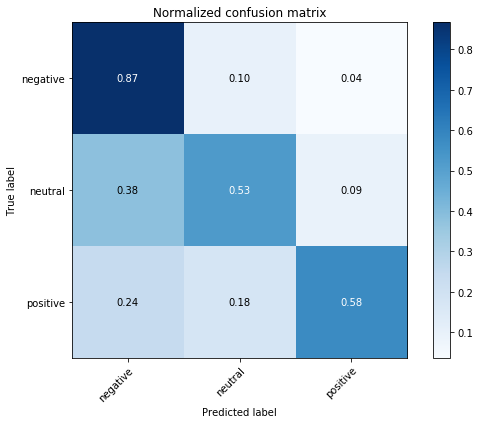

In [161]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_encoded, y_pred, 
                      classes=class_names, 
                      normalize=True,
                      title='Normalized confusion matrix')

In [162]:
print("classification report:")
print(classification_report(y_test_encoded, y_pred,
                            target_names=class_names,
                           ))

classification report:
              precision    recall  f1-score   support

    negative       0.83      0.87      0.85      1889
     neutral       0.54      0.53      0.53       580
    positive       0.68      0.58      0.63       459

   micro avg       0.75      0.75      0.75      2928
   macro avg       0.68      0.66      0.67      2928
weighted avg       0.75      0.75      0.75      2928



14:36:08 update_title_pos
14:36:08 update_title_pos
14:36:08 update_title_pos
14:36:08 update_title_pos
14:36:08 update_title_pos


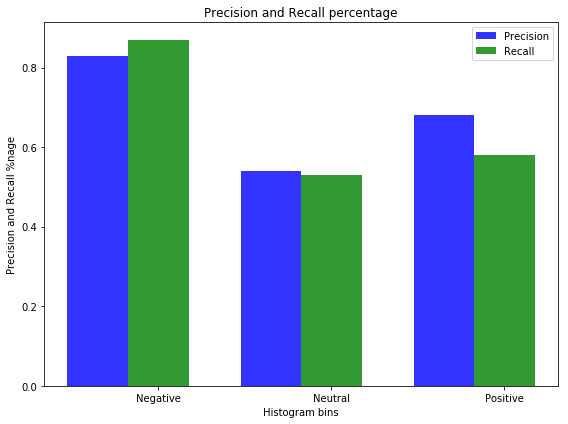

In [163]:
vertical_chart(means_precision  = [0.83, 0.54, 0.68], 
               means_recall = [0.87, 0.53, 0.58])